In [88]:
import h5py
import numpy as np
import bisect
import matplotlib.pyplot as plt 
from astropy.io import ascii
import speclite.filters
from astropy import units as u
from astropy import constants as const

In [89]:
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

# Kasen+17
- https://github.com/dnkasen/Kasen_Kilonova_Models_2017

In [120]:
def read_kasen_model(name, t=2.0):
	fin = h5py.File(name,'r')

	# frequency in Hz
	nu    = np.array(fin['nu'],dtype='d')*u.Hz
	# array of time in seconds
	times = np.array(fin['time'])
	# covert time to days
	times = times/3600.0/24.0

	# specific luminosity (ergs/s/Hz) 
	# this is a 2D array, Lnu[times][nu]
	Lnu_all   = np.array(fin['Lnu'],dtype='d')*u.erg/u.second/u.Hz

	# index corresponding to t
	it = bisect.bisect(times,t)
	# spectrum at this epoch
	Lnu = Lnu_all[it,:]

	# if you want thing in Flambda (ergs/s/Angstrom)
	c    = const.c
	lam  = (c/nu).to(u.Angstrom)
	Llam = (Lnu*nu**2.0/c).to(u.erg/u.second/u.Angstrom)

	return lam, Llam, nu, Lnu

Text(0.09, 0.5, '$\\rm L_{\\lambda}$')

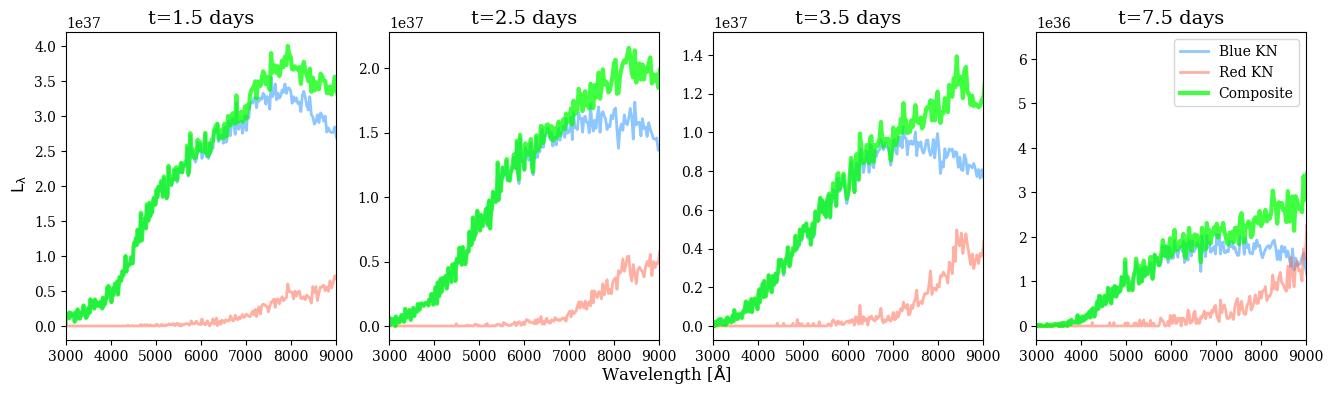

In [130]:
# open model file
path_model = '../3.table/Kasen_Kilonova_Models_2017-master/kilonova_models'

#	Blue KN
bname = f'{path_model}/knova_d1_n10_m0.025_vk0.30_Xlan1e-4.0.h5'
#	Red KN
rname = f'{path_model}/knova_d1_n10_m0.040_vk0.15_Xlan1e-1.5.h5'

# t = 1.0
times = [1.5, 2.5, 3.5, 7.5]

fig = plt.figure(figsize=(16, 4))
for ii, t in enumerate(times):
	plt.subplot(1, len(times), ii+1)

	blam, bLlam, bnu, bLnu = read_kasen_model(bname, t=t)
	rlam, rLlam, rnu, rLnu = read_kasen_model(rname, t=t)

	#	Combined KN
	lam = blam
	Llam = bLlam+rLlam

	#plot it up
	plt.title(f't={t:1.1f} days')

	plt.plot(blam, bLlam, c='dodgerblue', lw=2, alpha=0.5, label='Blue KN')
	plt.plot(rlam, rLlam, c='tomato', lw=2, alpha=0.5, label='Red KN')
	plt.plot(lam, Llam, c='lime', lw=3, alpha=0.75, label='Composite')
	plt.xlim([3000, 9000])

plt.ion()
plt.legend()

fig.text(0.5, 0.01, r'Wavelength [$\rm \AA$]', ha='center', fontsize=12)
fig.text(0.09, 0.5, r'$\rm L_{\lambda}$', va='center', rotation='vertical', fontsize=12)


# 7DT med-bands

In [131]:
rsptbl = ascii.read('../3.table/7dt.filter.response.realistic_optics.ecsv')
filterlist = np.unique(rsptbl['name'])

for filte in filterlist:
	#	Filter Table
	fltbl = rsptbl[rsptbl['name']==filte]

	_ = speclite.filters.FilterResponse(
		wavelength = fltbl['lam'],
		response = fltbl['response'], meta=dict(group_name='med', band_name=filte)
	)

#	New name for speclite class
mfilterlist = [f"med-{filte}" for filte in filterlist]

#	Medium filters
meds = speclite.filters.load_filters(*mfilterlist)

In [132]:
t=0.45

blam, bLlam, bnu, bLnu = read_kasen_model(bname, t=t)
rlam, rLlam, rnu, rLnu = read_kasen_model(rname, t=t)

#	Combined KN
lam = blam
Llam = bLlam+rLlam
Lnu = bLnu+rLnu

/Users/paek/opt/miniconda3/envs/kn/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


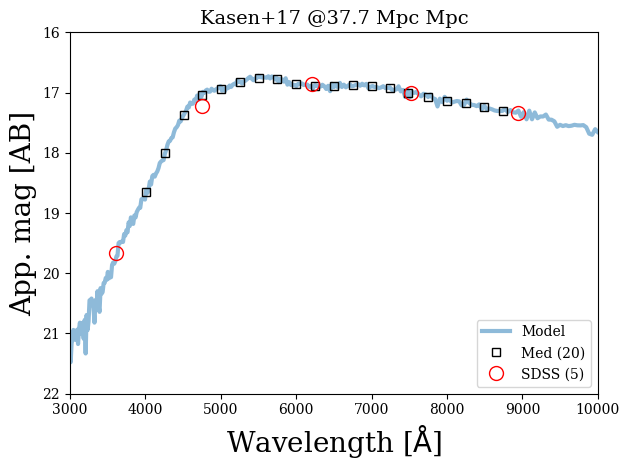

In [191]:
flam = Llam/(4*np.pi*d**2)
fnu = Lnu/(4*np.pi*d**2)
abmag = fnu.to(u.ABmag)
#

mags = meds.get_ab_magnitudes(flam[np.argsort(lam)], lam[np.argsort(lam)])
#	SDSS
smags = sdss.get_ab_magnitudes(flam[np.argsort(lam)], lam[np.argsort(lam)])

#
plt.title(f'Kasen+17 @{d:1.1f} Mpc')
plt.plot(lam, abmag, lw=3, alpha=0.5, label='Model')
plt.plot(meds.effective_wavelengths, mags.as_array().item(), marker='s', mec='k', mfc='none', ms=6, ls='none', label=f'Med ({len(mags.keys())})')
plt.plot(sdss.effective_wavelengths, smags.as_array().item(), marker='o', mec='red', mfc='none', ms=10, ls='none', label=f'SDSS ({len(smags.keys())})')

plt.xlim([3000, 10000])
plt.ylim([22, 16])
# yl, yu = plt.ylim()
# plt.ylim([yu, yl])
# plt.tight_layout()
plt.xlabel('Wavelength'+r' [$\rm \AA$]')
plt.ylabel('App. mag [AB]')
plt.legend()

for key in mags.keys():
	mags[key].format = '1.3f'

for key in smags.keys():
	smags[key].format = '1.3f'

plt.tight_layout()
plt.savefig('../4.plot/test.kasen.7dt.synphot.png')

In [95]:
d = 37.7*u.Mpc

lam = lam[np.argsort(lam)]
Llam = Llam[np.argsort(lam)] # [ergs/s/Angstrom]
flam = Llam/(4*np.pi*d**2)

flam

mags = meds.get_ab_magnitudes(flam, lam)
mags

med-m400,med-m425,med-m450,med-m475,med-m500,med-m525,med-m550,med-m575,med-m600,med-m625,med-m650,med-m675,med-m700,med-m725,med-m750,med-m775,med-m800,med-m825,med-m850,med-m875
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
19.534853859962155,19.90606569387959,20.140236350159174,20.202438954593255,20.253998283508746,20.36574749531011,20.433740037556852,20.671907622389583,20.905824324845096,21.396572158849516,21.40430111744716,21.757727172602074,21.80629624751171,21.98029028224982,22.161542586511615,22.93087575014934,22.569966492601317,24.294362745867044,23.538804637522905,23.87831585382947


# 7DT Broad-bands

In [96]:
rsptbl = ascii.read('../3.table/sdss.filter.response.realistic_optics.ecsv')

filterlist = np.unique(rsptbl['name'])

# for filte in filterlist:
for filte in ['u', 'g', 'r', 'i']:
	#	Filter Table
	fltbl = rsptbl[rsptbl['name']==filte]

	_ = speclite.filters.FilterResponse(
		wavelength = fltbl['lam'],
		response = fltbl['response'], meta=dict(group_name='broad', band_name=filte)
	)

#	New name for speclite class
bfilterlist = [f"broad-{filte}" for filte in filterlist]

#	Medium filters
broads = speclite.filters.load_filters(*bfilterlist)


In [97]:
sdss = speclite.filters.load_filters('sdss2010-*')

In [111]:
# t=0.45
t = 4.5

blam, bLlam = read_kasen_model(bname, t=t)
rlam, rLlam = read_kasen_model(rname, t=t)

#	Combined KN
lam = blam
Llam = bLlam+rLlam

(0.0, 3.0)

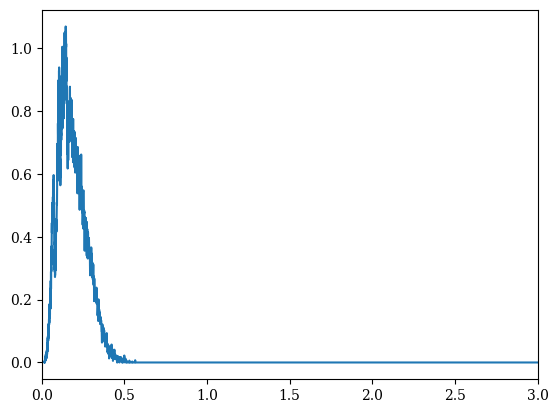

In [119]:
plt.plot(lam.to(u.um), Llam.to(u.erg/u.second/u.um)/1e41)

plt.xlim([0, 3.0])

In [112]:
d = 37.7*u.Mpc

lam = lam[np.argsort(lam)]
Llam = Llam[np.argsort(lam)] # [ergs/s/Angstrom]
flam = Llam/(4*np.pi*d**2)

# mags = broads.get_ab_magnitudes(flam, lam)
mags = sdss.get_ab_magnitudes(flam, lam)
mags

/Users/paek/opt/miniconda3/envs/kn/lib/python3.10/site-packages/speclite/filters.py:1118: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(maggies)


sdss2010-u,sdss2010-g,sdss2010-r,sdss2010-i,sdss2010-z
float64,float64,float64,float64,float64
22.666688383550124,24.49803329044634,29.2907824148805,inf,inf


In [110]:
lam[0] < lam[1]

True

(3000.0, 9000.0)

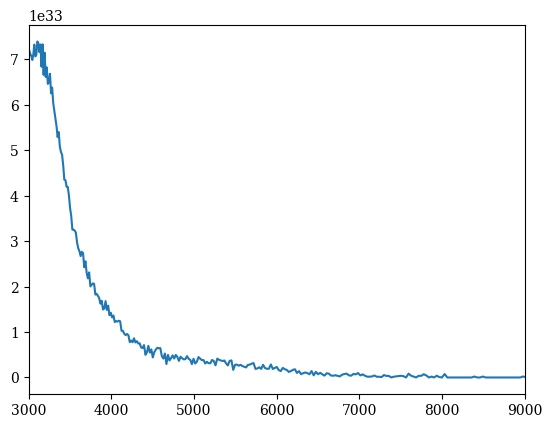

In [107]:
plt.plot(lam, flam)

plt.xlim([3000, 9000])


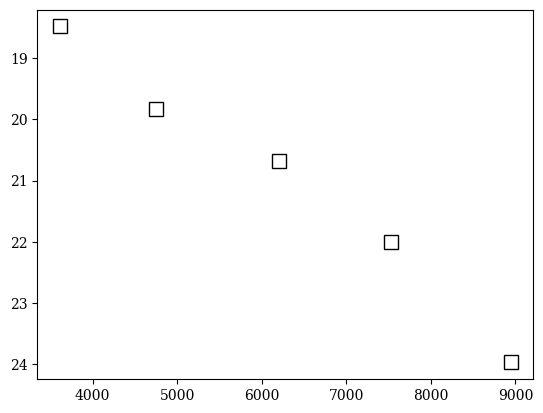

In [100]:
plt.plot(sdss.effective_wavelengths, mags.as_array().item(), marker='s', mec='k', mfc='none', ls='none', ms=10)

yl, yu = plt.ylim()
_ = plt.ylim([yu, yl])